In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  5 14:35:35 2025
Compare laminar profile
fig 5 in the paper
@author: yuhui
"""
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import pandas as pd
from statsmodels.stats.anova import AnovaRM
from scipy.stats import f
from scipy.stats import t

In [ ]:
# Define data directory
data_dir = '/media/yuhui/LCT'

# Define layer parameters
layer_num = 18
depth = np.linspace(0, 1, layer_num)  # Cortical depth

# Get subject list
search_pattern = f"{data_dir}/2*/bold.sft/layerProfileSUMA/stats*.rbold.benson14_v1.ProbMM_valueSH.1D"
subj_list = sorted(glob.glob(search_pattern))

subj_num = len(subj_list)
print(f"Processing {subj_num} subjects")

laydiff_pp_sh_norm_all = np.zeros((subj_num, layer_num))
laydiff_fb_sh_norm_all = np.zeros((subj_num, layer_num))

lay_pp_sh_all = np.zeros((subj_num, layer_num))
lay_pp_norm_all = np.zeros((subj_num, layer_num))
lay_fb_sh_all = np.zeros((subj_num, layer_num))
lay_fb_norm_all = np.zeros((subj_num, layer_num))

Processing 20 subjects


In [ ]:
# %% Loop through subjects
for subj_idx, subj_file in enumerate(subj_list):
    subj_folder = os.path.dirname(subj_file)

    # Define effect list
    effect_list = [
        os.path.join(subj_folder, 'stats3.rbold.pos_PALS_vpfc.ProbLH_valueLH.1D'),
        os.path.join(subj_folder, 'stats3.rbold.pos_PALS_vpfc.ProbMM_valueLH.1D'),
        os.path.join(subj_folder, 'stats3.rbold.pos_PALS_vpfc.ProbMM_valueSH.1D'),
        os.path.join(subj_folder, 'stats3.rbold.pos_PALS_vpfc.AR_GAINLOSS_norm.1D'),
        os.path.join(subj_folder, 'stats3.rbold.pos_PALS_vpfc.AR_GAINLOSS_sh.1D')
    ]

    # Load data
    effect_all = np.zeros((len(effect_list), layer_num))
    for idx, effect_file in enumerate(effect_list):
        effect_data = np.loadtxt(effect_file)

        effect_pc = effect_data[0, :]
        effect_pc = np.flip(effect_pc)
        effect_all[idx, :] = effect_pc

    lay_pp_sh_all[subj_idx, :] = effect_all[2, :]
    lay_pp_norm_all[subj_idx, :] = (effect_all[1, :] + effect_all[0, :]) / 2
    lay_fb_sh_all[subj_idx, :] = effect_all[4, :]
    lay_fb_norm_all[subj_idx, :] = effect_all[3, :]
    
    # normalize it to get rid of the BOLD superficial bias
    laydiff_pp_sh_norm_all[subj_idx, :] = lay_pp_sh_all[subj_idx, :] / lay_pp_norm_all[subj_idx, :]
    laydiff_fb_sh_norm_all[subj_idx, :] = lay_fb_sh_all[subj_idx, :] / lay_fb_norm_all[subj_idx, :]

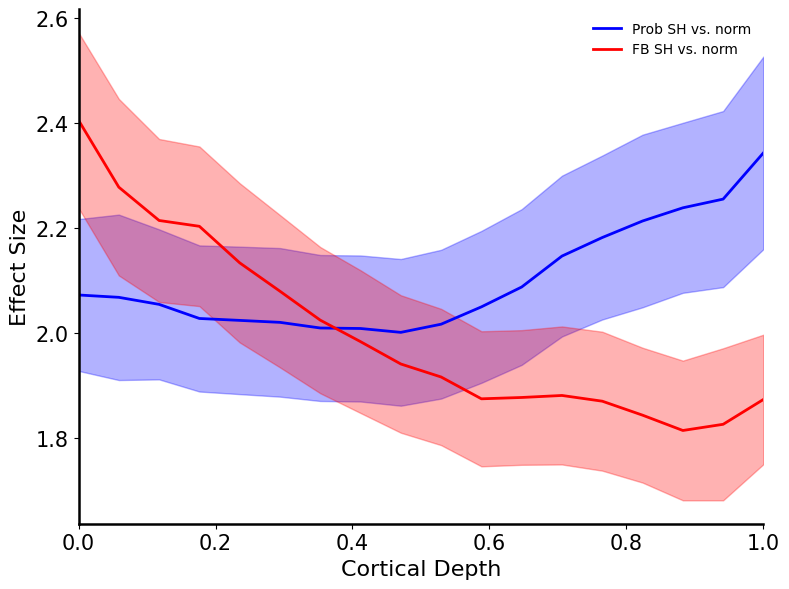

In [234]:
# %% group laminar profile for lay diff between Prob SH and norm
# Compute mean and SEM across subjects
effect_mean1 = np.mean(laydiff_pp_sh_norm_all, axis=0)
effect_sem1 = np.std(laydiff_pp_sh_norm_all, axis=0)/np.sqrt(subj_num)

effect_mean2 = np.mean(laydiff_fb_sh_norm_all, axis=0)
effect_sem2 = np.std(laydiff_fb_sh_norm_all, axis=0)/np.sqrt(subj_num)

# Define plot directory
plot_dir = os.path.join(data_dir, 'group')
os.makedirs(plot_dir, exist_ok=True)
# Plot results with SINGLE Y-axis
fig, ax = plt.subplots(figsize=(8, 6))
# Plot Prob SH (blue)
ax.fill_between(depth, effect_mean1 - effect_sem1, effect_mean1 + effect_sem1, color='blue', alpha=0.3)
ax.plot(depth, effect_mean1, '-b', linewidth=2, label="Prob SH vs. norm")
# Plot FB SH (red)
ax.fill_between(depth, effect_mean2 - effect_sem2, effect_mean2 + effect_sem2, color='red', alpha=0.3)
ax.plot(depth, effect_mean2, '-r', linewidth=2, label="FB SH vs. norm")
# Labels and Title
ax.set_xlabel('Cortical Depth', fontsize=16, fontweight='normal')
ax.set_ylabel('Effect Size', fontsize=16, fontweight='normal')
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.set_xlim([0, 1])
# Remove the box around the legend
ax.legend(frameon=False) # loc='best',
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Increase the thickness of the x and y axes
ax.spines['left'].set_linewidth(1.8)  # Y-axis thickness
ax.spines['bottom'].set_linewidth(1.8)  # X-axis thickness
# # Show plot
# plt.show()
plt.tight_layout()
plt.savefig("output/layerprofile.png", dpi=300, bbox_inches='tight')


In [ ]:
# %% Compare Superficial vs. Deep Layers

# Define superficial (layers 1-9) and deep (layers 10-18)
mean_superficial_pp = np.mean(laydiff_pp_sh_norm_all[:, 0:9], axis=1)
mean_deep_pp = np.mean(laydiff_pp_sh_norm_all[:, 9:18], axis=1)
mean_superficial_fb = np.mean(laydiff_fb_sh_norm_all[:, 0:9], axis=1)
mean_deep_fb = np.mean(laydiff_fb_sh_norm_all[:, 9:18], axis=1)

# Perform paired t-tests
t_stat_pp, p_value_pp = stats.ttest_rel(mean_superficial_pp, mean_deep_pp)
t_stat_fb, p_value_fb = stats.ttest_rel(mean_superficial_fb, mean_deep_fb)
df = subj_num - 1

# Compute Cohen's d for paired samples
diff_pp = mean_superficial_pp - mean_deep_pp
cohen_d_pp = np.mean(diff_pp) / np.std(diff_pp, ddof=1)

diff_fb = mean_superficial_fb - mean_deep_fb
cohen_d_fb = np.mean(diff_fb) / np.std(diff_fb, ddof=1)

# Collect p-values for multiple comparison correction
p_values = [p_value_pp, p_value_fb]

# Apply Benjamini-Hochberg (FDR) correction
corrected_p_values = multipletests(p_values, alpha=0.05, method='fdr_bh')[1]

# Assign corrected values
p_value_pp_corrected, p_value_fb_corrected = corrected_p_values

# Prepare data for the table
results_table = pd.DataFrame({
    "Condition": ["Choice Stage (Prob SH)", "Feedback Stage (FB SH)"],
    "t-value": [t_stat_pp, t_stat_fb],
    "p-value (uncorrected)": [p_value_pp, p_value_fb],
    "Cohen's d": [cohen_d_pp, cohen_d_fb],
    "p-value (FDR-corrected)": corrected_p_values,
    "df": [df, df]
})

# Print table
print(results_table.to_string(index=False))

             Condition   t-value  p-value (uncorrected)  Cohen's d  p-value (FDR-corrected)  df
Choice Stage (Prob SH) -2.236183               0.037532  -0.500026                 0.037532  19
Feedback Stage (FB SH)  4.559046               0.000214   1.019434                 0.000429  19


In [ ]:
# Main effect of Layer: Are superficial and deep responses different overall?
# Main effect of Stage: Are responses different between Choice and Feedback?
# Interaction: Does the difference between superficial vs. deep change across Stage?

subjects = np.arange(subj_num)

# Prepare data
df_anova = pd.DataFrame({
    'Subject': np.concatenate([subjects]*4),
    'Layer': ['Superficial']*subj_num + ['Deep']*subj_num + ['Superficial']*subj_num + ['Deep']*subj_num,
    'Stage': ['Choice']*2*subj_num + ['Feedback']*2*subj_num,
    'Value': np.concatenate([
        mean_superficial_pp,
        mean_deep_pp,
        mean_superficial_fb,
        mean_deep_fb
    ])
})

# Convert to categorical
df_anova['Subject'] = df_anova['Subject'].astype(str)

# Run 2x2 repeated-measures ANOVA
aov = AnovaRM(df_anova, depvar='Value', subject='Subject', within=['Layer', 'Stage'])
anova_results = aov.fit()
print(anova_results)

                  Anova
            F Value Num DF  Den DF Pr > F
-----------------------------------------
Layer        3.5505 1.0000 19.0000 0.0749
Stage        1.0791 1.0000 19.0000 0.3119
Layer:Stage 17.8817 1.0000 19.0000 0.0005



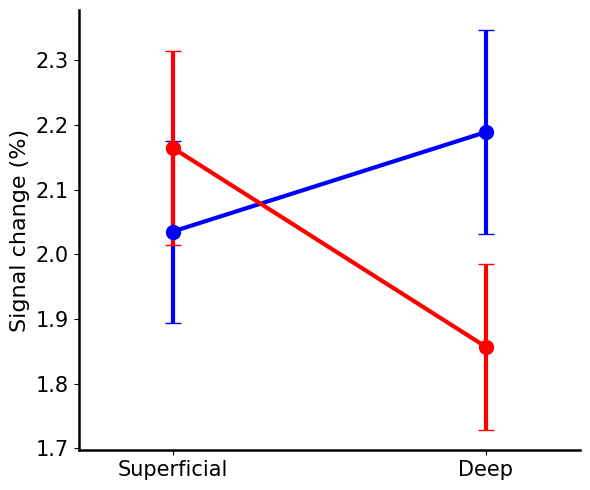

In [ ]:
# Example means and SEMs (replace with your actual data)
means = [
    [np.mean(mean_superficial_pp), np.mean(mean_deep_pp)],  # Prob SH
    [np.mean(mean_superficial_fb), np.mean(mean_deep_fb)]   # FB SH
]
sems = [
    [np.std(mean_superficial_pp) / np.sqrt(len(mean_superficial_pp)),
     np.std(mean_deep_pp) / np.sqrt(len(mean_deep_pp))],
    [np.std(mean_superficial_fb) / np.sqrt(len(mean_superficial_fb)),
     np.std(mean_deep_fb) / np.sqrt(len(mean_deep_fb))]
]

# X-axis labels and positions
x = np.arange(2)
x_labels = ["Superficial", "Deep"]

fig, ax = plt.subplots(figsize=(6, 5))

# Plot lines and error bars for Prob SH (blue) and FB SH (red)
ax.errorbar(x, means[0], yerr=sems[0], color='blue', marker='o', linewidth=3, markersize=10, capsize=6, label='Prob SH')
ax.errorbar(x, means[1], yerr=sems[1], color='red', marker='o', linewidth=3, markersize=10, capsize=6, label='FB SH')

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(x_labels, fontsize=16)
ax.set_ylabel("Signal change (%)", fontsize=16)
ax.tick_params(axis='y', labelsize=14)
# ax.set_ylim(0, y_max * 1.2)
ax.set_xlim(-0.3, 1.3)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.8)
ax.spines['bottom'].set_linewidth(1.8)
# ax.legend(frameon=False, fontsize=14, loc='upper center')

# plt.tight_layout()
# plt.show()
plt.tight_layout()
plt.savefig("output/layerprofile1.png", dpi=300, bbox_inches='tight')